<a href="https://colab.research.google.com/github/alizeed7/SYSC4415/blob/main/SYSC4415W25_A2_ALIZEE_DROLET_101193138.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYSC4415 Assignment 2 – Fire Hydrant Detection 🚒

"""
Special thanks to Nader Ibrahim for assembling the dataset. For more details, please refer to the paper:

Ibrahim N, Dick K, Green JR. Computer Vision Fire Hydrant Obstruction Detection System. In2024 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE) 2024 Aug 6 (pp. 799-805). IEEE.


Questions? Please use the Brightspace Discussion Board.

Deadline: See Brightspace end date.
"""

## Instructions
DO NOT wait until the last minute to complete this assignment as training the models might take longer. Also leverage the free GPU provided by colab to make your training faster.


Follow all steps carefully. Your solutions must be self-contained in this notebook. No other supplementary materials or files will be accepted. As soon as I open your notebook, I will click "Runtime" → "Run all". Ensure your notebook runs without errors and displays results clearly.


You are asked to provide both code and text to address discussion questions. For the text answers, see the markdown cells with the ❓ emoji for questions and enter your answers following the ✅ emoji.

Provide sufficient comments in your code to describe its functionality. Do not remove any necessary libraries as this will cause errors.

Download the dataset from Brightspace and store it in your Google Drive under "My Drive" (not in any subfolder). Check the file location via right-click → File Information → Details → Location.

Submit your notebook as a `.ipynb` file named: `SYSC4415W25_A2_FIRSTNAME_LASTNAME_StudentID.ipynb` on Brightspace. No other submission methods will be accepted.


## Dataset
Provided on Brightspace.

#### Dataset details:
- Training Images: 2,272  
- Validation Images: 563  
- Labels: 0 = No Fire Hydrant, 1 = Fire Hydrant  
- Imbalanced dataset (most images do not contain a hydrant).

#### Dataset Information
The dataset contains two main folders:
- `train/`: Contains the training images and a CSV file with labels.
- `valid/`: Contains the validation images and a CSV file with labels.

Each folder includes:
- Images of fire hydrants and non-fire hydrants.
- A CSV file (`_classes.csv`) mapping each image filename to its label:
  - `0` for no fire hydrant.
  - `1` for fire hydrant.

Ensure the zip file of the dataset (FH_detection_data.zip) to your Google Drive and placed under "My Drive" without any subfolders to keep the paths consistent.



## Steps

### 1) Initial Setup
Import necessary libraries


In [7]:
# Import all the necessary libraries here

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torchvision.transforms as transforms

Mount Google Drive and unzip the dataset.

In [8]:
## Code provided by Akash. DO NOT CHANGE THIS CELL

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip /content/drive/MyDrive/FH_detection_data.zip -d /content/


# Dataset path
train_data_path = "/content/train"
valid_data_path = "/content/valid"
train_label = pd.read_csv('/content/train/_classes.csv')
valid_label = pd.read_csv('/content/valid/_classes.csv')

Mounted at /content/drive
Archive:  /content/drive/MyDrive/FH_detection_data.zip
   creating: /content/train/
 extracting: /content/train/10063782964_891eedde4e_z_jpg.rf.4caba9d0e35546b469aa896df780d833.jpg  
 extracting: /content/train/100_PNG.rf.d52fbff94c483761d0644a1e8abe4c95.jpg  
 extracting: /content/train/101_PNG.rf.f1335e18f815c8c8044a94c09db7f025.jpg  
 extracting: /content/train/102378468_d8132a415b_z_jpg.rf.6bc008d0d532d3365f580b7aaa7623e3.jpg  
 extracting: /content/train/102_PNG.rf.160c945e0881c92a078a14069d9a6b9a.jpg  
 extracting: /content/train/102_jpg.rf.17df75e9dda0f851c9f5e1d554f07488.jpg  
 extracting: /content/train/103357395_388d701e12_z_jpg.rf.a54c985e93402af49ba422f005e702d8.jpg  
 extracting: /content/train/103_jpg.rf.a649213f3998906bf2298607f82ee839.jpg  
 extracting: /content/train/104351403_25e959f878_z_jpg.rf.43156bd0a74313df69967d88e5e6a268.jpg  
 extracting: /content/train/104_PNG.rf.c14671a6a52ae05f9ae2bf1df7e4316e.jpg  
 extracting: /content/train/104_

----

### 2) Data Exploration
1. Load dataset into a pandas DataFrame.
2. Display display three sample images from each class
3. Create separately class distribution plots of the train and validation data
[Requires 6 sample images (three from each class) and two plots of class distribution (train and validation)]

❓ Why is it important to check for class imbalance before training? How might this affect our model?  
✅ It is important to check for class imbalance before training because it helps to know if there are any classes in the dataset that significantly outnumbers the instances of other classes. If there are more images of no fire hydrants than fire hydrants, the model may learn to predict the majority class most of the time, resulting in poor generalization.



Train Data Sample:
                                            filename  Fire Hydrants
0  45-394823_-75-62419684_heading270_jpg.rf.01200...              0
1  53-4733_-113-44139_heading180_jpg.rf.00a4904dd...              0
2     49_jpg.rf.00d3bdf822d633cc6d6fe5ed2c248a59.jpg              1
3  download_jpeg_jpg.rf.00666bac2a7d67fe8f26db4a7...              1
4  45-42126683_-75-64919699_heading270_jpg.rf.02d...              1
Validation Data Sample:
                                            filename  Fire Hydrants
0  45-41883112_-75-66552927_heading270_jpg.rf.5e3...              0
1  45-42123726_-75-65002237_heading0_jpg.rf.5e41f...              0
2  53-4765_-113-46208_heading90_jpg.rf.5ea9d57ca3...              0
3  45-41625342_-75-67819976_heading0_jpg.rf.5eba1...              0
4  45-42248701_-75-69599839_heading180_jpg.rf.698...              0


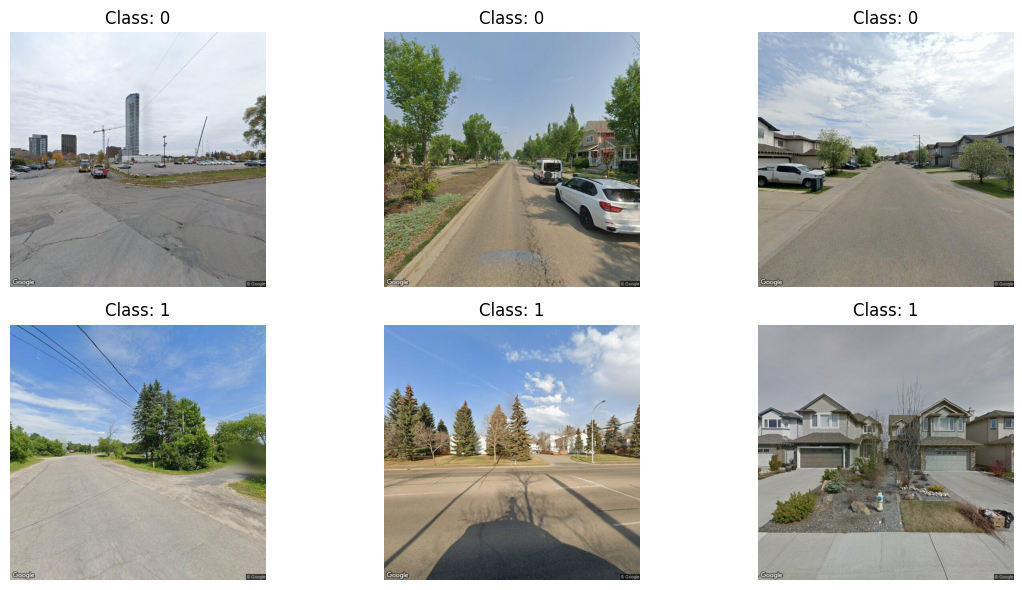

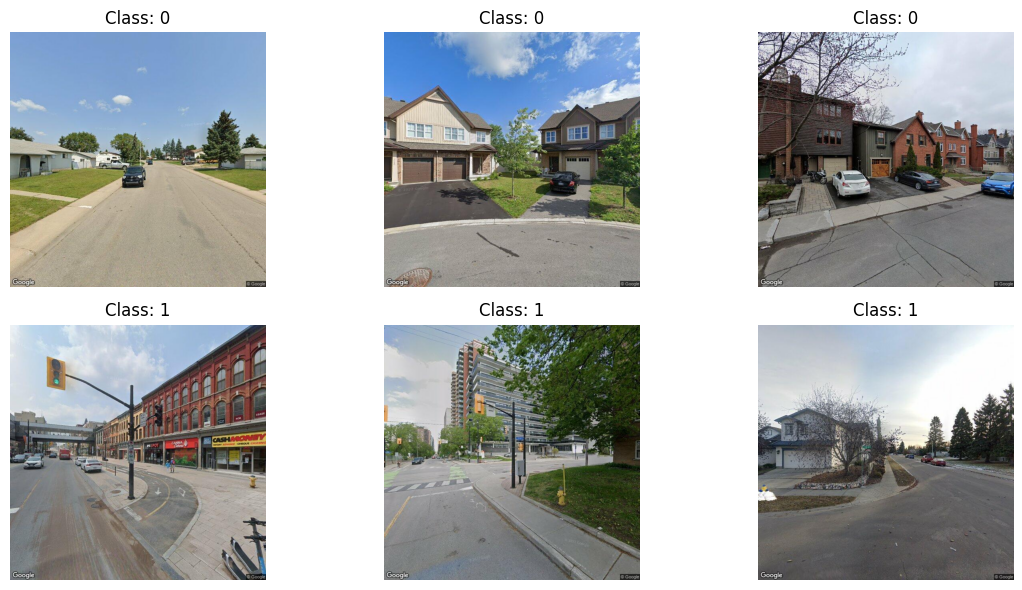

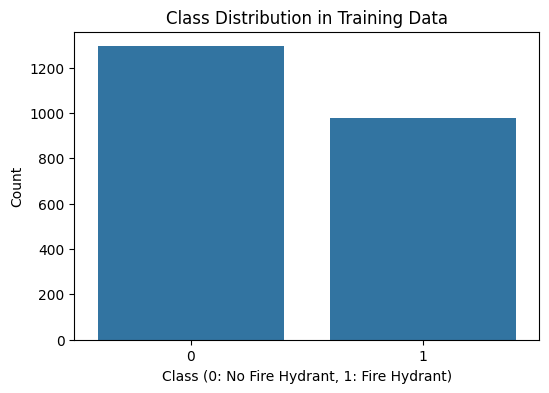

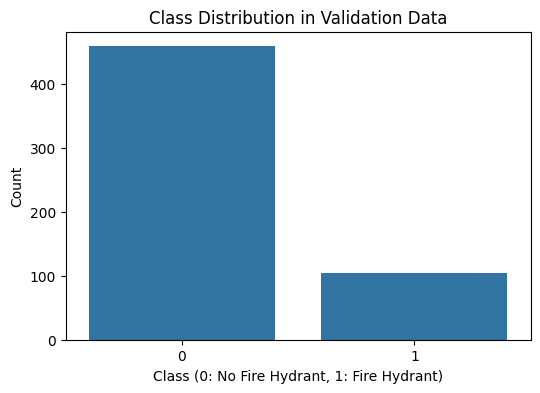

In [9]:
#The dataset is already a pandas DataFrame from the last two lines of code in the last block
print("Train Data Sample:")
print(train_label.head())
print("Validation Data Sample:")
print(valid_label.head())

def display_sample_images(df, data_path):
  fig, axes = plt.subplots(2, 3, figsize=(12, 6))

  for label in [0, 1]:
    class_images = df[df['Fire Hydrants'] == label]['filename'].sample(3)
    for i, image_name in enumerate(class_images):
      image_path = os.path.join(data_path, image_name)
      image = plt.imread(image_path)
      axes[label, i].imshow(image)
      axes[label, i].set_title(f"Class: {label}")
      axes[label, i].axis('off')

  plt.tight_layout()
  plt.show()

# Display sample images from training data
display_sample_images(train_label, train_data_path)
# Display sample images from validation data
display_sample_images(valid_label, valid_data_path)

def plot_class_distribution(df, title):
  plt.figure(figsize=(6, 4))
  sb.countplot(x='Fire Hydrants', data=df)
  plt.title('Class Distribution in ' + title)
  plt.xlabel('Class (0: No Fire Hydrant, 1: Fire Hydrant)')
  plt.ylabel('Count')
  plt.show()

plot_class_distribution(train_label, 'Training Data')
plot_class_distribution(valid_label, 'Validation Data')

---

### 3) Preprocessing
- Resize images to 128x128.
- Apply any other necessary transformations that you feel can help.

❓ Would one-hot encoding be necessary for binary classification? Why or why not?  
✅ It is unnecessary for binary classification, because the task can be represented by a single scalar value (0 or 1). This is usually done after applying a sigmoid function which forces the output to have a scalar probability between 0 and 1.

In [10]:
from PIL import Image

# Resize images to 128x128, flip and rotate images, and convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor()])

# Create a custom dataset class to apply transformation to each image
class FireHydrantDataset(torch.utils.data.Dataset):
  def __init__(self, image_path, label_df, transform=None):
    self.image_path = image_path
    self.labels = pd.read_csv(label_df)
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    img_name = os.path.join(self.image_path, self.labels.iloc[index, 0])
    image = Image.open(img_name)
    label = torch.tensor(self.labels.iloc[index, 1], dtype=torch.float32)
    if self.transform:
      image = self.transform(image)
    return image, label

# Load the datasets
train_dataset = FireHydrantDataset(train_data_path, '/content/train/_classes.csv', transform=transform)
valid_dataset = FireHydrantDataset(valid_data_path, '/content/valid/_classes.csv', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

# # Display some sample images
# def show_samples(dataset):
#     fig, axes = plt.subplots(1, 3, figsize=(10, 5))
#     indices = [i for i in range(len(dataset)) if dataset[i][1] == 1][:3]
#     for i, idx in enumerate(indices):
#         img, label = dataset[idx]
#         axes[i].imshow(img.permute(1, 2, 0))
#         axes[i].set_title(f'Class: {int(label)}')
#     plt.show()

# print("Fire Hydrant Samples:")
# show_samples(train_dataset)

# print("No Fire Hydrant Samples:")
# show_samples(valid_dataset)


---

### 4) Creating the Baseline Model
Create a CNN with:
- Two convolutional layers to extract features from the images.
- Max pooling layers after each convolution to reduce spatial dimensions.
- Fully connected layers to perform classification.
- A sigmoid activation function at the output layer to output a probability between 0 and 1.

Required architecture:
- Input: RGB images resized to 128x128 pixels.
- Conv2d (3 input channels, 32 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the first Conv2d.
- Conv2d (32 input channels, 64 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the second Conv2d.
- Flatten
- Linear layer with 128 units
- Output Linear layer with 1 unit and sigmoid activation



This model will be trained to classify whether an image contains a fire hydrant or not.


❓ List three ways to improve the baseline model (e.g., adding dropout to... , using batch normalization to..., or increasing the number of layers to...,
be sure to come up with your own ideas!). Provide a brief explanation for each.

✅
 1. Increase the number of units in the layers. This allows the model to have more capacity to learn complex patterns in the data and improve the classification performance.
 2. Use pretrained models instead of training one from scratch. These models have already learned useful features from extremely large datasets, so fine-tuning them on fire hydrant detection can help achieve better performance with less data and computational resources.
 3. Increase filter size (kernel size) in the layers. Using larger filters can help include larger spatial features in the images. If the fire hydrants varies in size or is surrounded by different types of backgrounds, it may be helpful to include that in the training process.


In [11]:
class BaselineCNN(torch.nn.Module):
  def __init__(self):
    super(BaselineCNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.flatten = torch.nn.Flatten()

    self.fc1 = torch.nn.Linear(64 * 32 * 32, 128)
    self.fc2 = torch.nn.Linear(128, 1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
    x = self.pool1(torch.relu(self.conv1(x)))
    x = self.pool2(torch.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = torch.relu(self.fc1(x))
    x = self.sigmoid(self.fc2(x))
    return x


---

### 5) Training and Evaluation
Train your CNN using Binary Cross Entropy Loss and an Adam optimizer. Use a learning rate of 0.001. Iterate over your dataset for 10 epochs and track the loss. Train using the train data in /train.

Evaluate your model on the test data in /valid using Precision, Recall, and F1-Score to assess performance.


❓ Which evaluation metric you think is the most suitable in our case, and why?

✅ Your answer here


Display the confusion matrix.

❓ Explain the confusion matrix to a non-technical audience and relate it to your chosen metric.  
✅ Your answer here

Epoch 1, Loss: 0.7349, Precision: 0.5026, Recall: 0.0982
Epoch 2, Loss: 0.6203, Precision: 0.6885, Recall: 0.4724
Epoch 3, Loss: 0.5699, Precision: 0.7096, Recall: 0.5521
Epoch 4, Loss: 0.5501, Precision: 0.7368, Recall: 0.5552
Epoch 5, Loss: 0.5366, Precision: 0.7200, Recall: 0.6022
Epoch 6, Loss: 0.5336, Precision: 0.7327, Recall: 0.5634
Epoch 7, Loss: 0.5096, Precision: 0.7494, Recall: 0.5900
Epoch 8, Loss: 0.5021, Precision: 0.7417, Recall: 0.5961
Epoch 9, Loss: 0.5025, Precision: 0.7601, Recall: 0.5767
Epoch 10, Loss: 0.4932, Precision: 0.7653, Recall: 0.5900
Finished Training
Validation Results - Precision: 0.2548, Recall: 0.8846, F1-Score: 0.3957


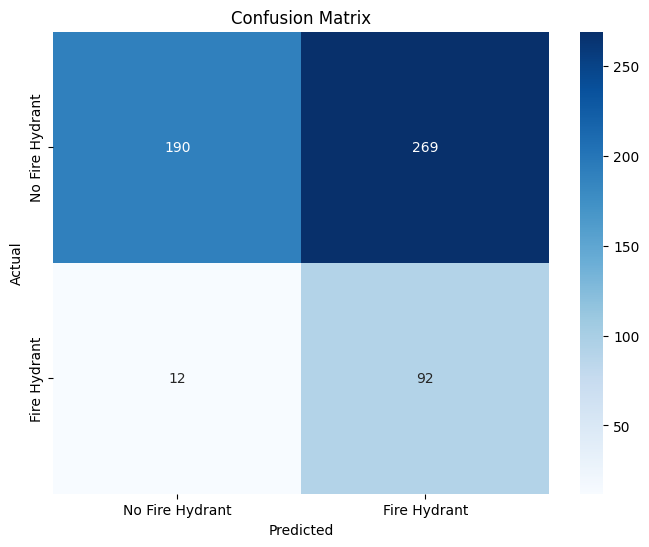

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Instantiate the model
model = BaselineCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
  model.train()
  running_loss = 0.0
  all_labels = []
  all_preds = []
  for images, labels in train_loader:
    labels = labels.view(-1, 1)
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # Store for metrics evaluation
    all_labels.extend(labels.detach().cpu().numpy())
    all_preds.extend((outputs.detach().cpu().numpy() > 0.5).astype(int))

  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print('Finished Training')

# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
  for images, labels in valid_loader:
    labels = labels.view(-1, 1)
    images = images.to(device)
    outputs = model(images)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend((outputs.cpu().numpy() > 0.5).astype(int))

# Compute precision, recall, and F1-score
precision = precision_score(np.array(all_labels), np.array(all_preds))
recall = recall_score(np.array(all_labels), np.array(all_preds))
f1 = f1_score(np.array(all_labels), np.array(all_preds))

print(f"Validation Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(np.array(all_labels), np.array(all_preds))

plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire Hydrant', 'Fire Hydrant'], yticklabels=['No Fire Hydrant', 'Fire Hydrant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


---


### 6) Model Improvements
Apply and evaluate three improvements ideas that you mentioned in the Baseline CNN question (Step 4).
Implement each idea separately, train a model with that improvement, and report the performance of each model using the metrics from Step 5. As above, train using the data in /train and test using the data in /valid.


❓ Which model would you deploy? Why?  
✅ Your answer here

In [13]:
# INCREASE UNITS IN LAYERS
# increase convolutional layer channels and increase the number of neurons in connected layers
class ImprovedCNN1(torch.nn.Module):
    def __init__(self):
        super(ImprovedCNN1, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1)  # 32 → 64
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64 → 128
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(128 * 32 * 32, 256)  # 128 → 256
        self.fc2 = torch.nn.Linear(256, 1)  # 128 → 256
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


Epoch 1, Loss: 0.8252, Precision: 0.5837, Recall: 0.2996
Epoch 2, Loss: 0.5877, Precision: 0.7469, Recall: 0.4857
Epoch 3, Loss: 0.5733, Precision: 0.7357, Recall: 0.5409
Epoch 4, Loss: 0.5524, Precision: 0.7385, Recall: 0.5746
Epoch 5, Loss: 0.5478, Precision: 0.7870, Recall: 0.5061
Epoch 6, Loss: 0.5269, Precision: 0.7545, Recall: 0.5624
Epoch 7, Loss: 0.5231, Precision: 0.7466, Recall: 0.5634
Epoch 8, Loss: 0.5173, Precision: 0.7547, Recall: 0.5726
Epoch 9, Loss: 0.5181, Precision: 0.7778, Recall: 0.5726
Epoch 10, Loss: 0.5065, Precision: 0.7729, Recall: 0.5777
Finished Training
Validation Results - Precision: 0.3929, Recall: 0.6346, F1-Score: 0.4853


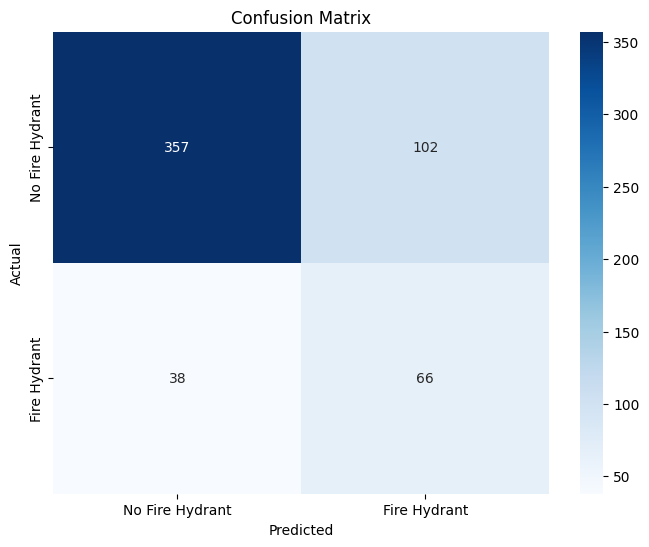

In [14]:
# TRAIN

# Instantiate the model
model = ImprovedCNN1()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
  model.train()
  running_loss = 0.0
  all_labels = []
  all_preds = []
  for images, labels in train_loader:
    labels = labels.view(-1, 1)
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # Store for metrics evaluation
    all_labels.extend(labels.detach().cpu().numpy())
    all_preds.extend((outputs.detach().cpu().numpy() > 0.5).astype(int))

  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print('Finished Training')

# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
  for images, labels in valid_loader:
    labels = labels.view(-1, 1)
    images = images.to(device)
    outputs = model(images)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend((outputs.cpu().numpy() > 0.5).astype(int))

# Compute precision, recall, and F1-score
precision = precision_score(np.array(all_labels), np.array(all_preds))
recall = recall_score(np.array(all_labels), np.array(all_preds))
f1 = f1_score(np.array(all_labels), np.array(all_preds))

print(f"Validation Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(np.array(all_labels), np.array(all_preds))

plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire Hydrant', 'Fire Hydrant'], yticklabels=['No Fire Hydrant', 'Fire Hydrant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---

In [15]:
# INCREASE KERNEL SIZE

class ImprovedCNN2(torch.nn.Module):
  def __init__(self):
    super(ImprovedCNN2, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=5, padding=2)  # Kernel 3 → 5
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=5, padding=2)  # Kernel 3 → 5
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.flatten = torch.nn.Flatten()

    self.fc1 = torch.nn.Linear(128 * 32 * 32, 256)
    self.fc2 = torch.nn.Linear(256, 1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
    x = self.pool1(torch.relu(self.conv1(x)))
    x = self.pool2(torch.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = torch.relu(self.fc1(x))
    x = self.sigmoid(self.fc2(x))
    return x


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Loss: 41.8471, Precision: 0.0000, Recall: 0.0000
Epoch 2, Loss: 56.2048, Precision: 0.4312, Recall: 0.9734
Epoch 3, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Epoch 4, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Epoch 5, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Epoch 6, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Epoch 7, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Epoch 8, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Epoch 9, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Epoch 10, Loss: 56.9542, Precision: 0.4305, Recall: 1.0000
Finished Training
Validation Results - Precision: 0.1847, Recall: 1.0000, F1-Score: 0.3118


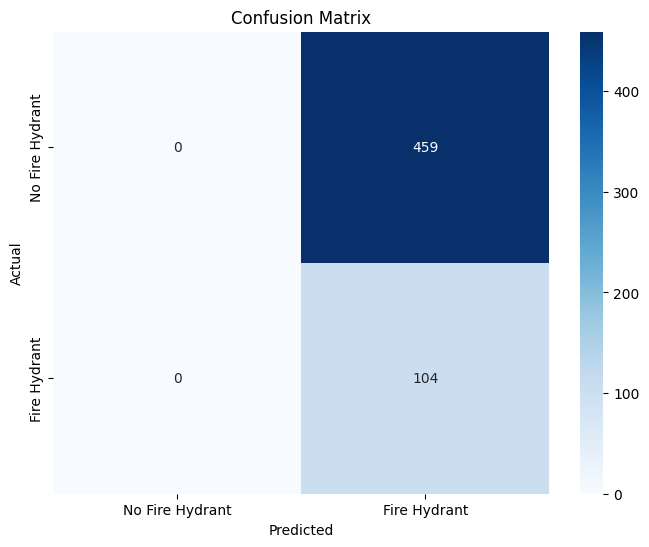

In [27]:
# TRAIN

# Instantiate the model
model = ImprovedCNN2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
  model.train()
  running_loss = 0.0
  all_labels = []
  all_preds = []
  for images, labels in train_loader:
    labels = labels.view(-1, 1)
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # Store for metrics evaluation
    all_labels.extend(labels.detach().cpu().numpy())
    all_preds.extend((outputs.detach().cpu().numpy() > 0.5).astype(int))

  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print('Finished Training')

# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
  for images, labels in valid_loader:
    labels = labels.view(-1, 1)
    images = images.to(device)
    outputs = model(images)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend((outputs.cpu().numpy() > 0.5).astype(int))

# Compute precision, recall, and F1-score
precision = precision_score(np.array(all_labels), np.array(all_preds))
recall = recall_score(np.array(all_labels), np.array(all_preds))
f1 = f1_score(np.array(all_labels), np.array(all_preds))

print(f"Validation Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(np.array(all_labels), np.array(all_preds))

plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire Hydrant', 'Fire Hydrant'], yticklabels=['No Fire Hydrant', 'Fire Hydrant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Add one more convolutional layer
class ImprovedCNN3(torch.nn.Module):
    def __init__(self):
        super(ImprovedCNN3, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(64 * 32 * 32, 128)  # Fixed feature size
        self.fc2 = torch.nn.Linear(128, 2)  # Output 2 classes instead of 1

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here; Softmax applied later
        return torch.softmax(x, dim=1)  # Apply Softmax across class scores

Epoch 1, Loss: 0.6944, Precision: 0.4403, Recall: 0.0603


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10, Loss: 0.6931, Precision: 0.0000, Recall: 0.0000
Finished Training


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Results - Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


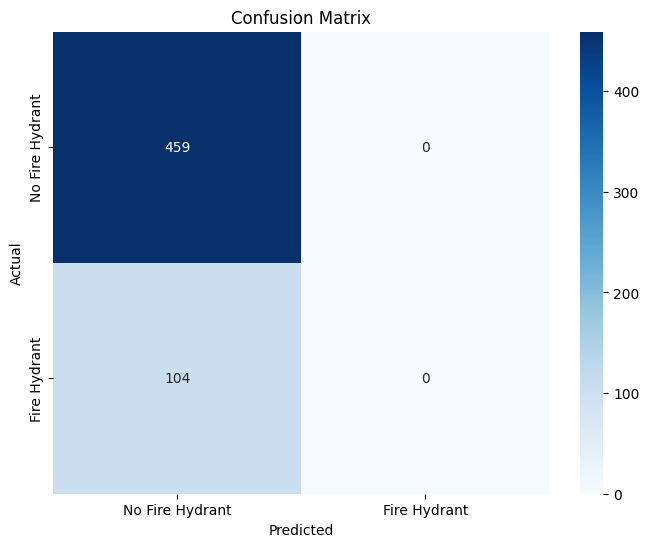

In [24]:
# TRAIN

# Instantiate the model
model = ImprovedCNN3()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
  model.train()
  running_loss = 0.0
  all_labels = []
  all_preds = []
  for images, labels in train_loader:
    labels = labels.view(-1, 1)
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = torch.sigmoid(model(images))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # Store for metrics evaluation
    all_labels.extend(labels.detach().cpu().numpy())
    all_preds.extend((outputs.detach().cpu().numpy() > 0.5).astype(int))

  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print('Finished Training')

# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
  for images, labels in valid_loader:
    labels = labels.view(-1, 1)
    images = images.to(device)
    outputs = model(images)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend((outputs.cpu().numpy() > 0.5).astype(int))

# Compute precision, recall, and F1-score
precision = precision_score(np.array(all_labels), np.array(all_preds))
recall = recall_score(np.array(all_labels), np.array(all_preds))
f1 = f1_score(np.array(all_labels), np.array(all_preds))

print(f"Validation Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(np.array(all_labels), np.array(all_preds))

plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire Hydrant', 'Fire Hydrant'], yticklabels=['No Fire Hydrant', 'Fire Hydrant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 7) Personal Inference Test
Test your trained model on at least FIVE new images (either collected using a camera or collected from the internet). Predict whether each image contains a fire hydrant and print the result.

Of your five images:
- Include at least one image of a fire hydrant that your model does not detect correctly.
- Include at least one image of a fire hydrant that your model does detect correctly.

❓ Challenge: Can you find an image that does not actually contain a fire hydrant, but your model believes that a hydrant is present?

✅ Your answer here

❓ Explain why you believe your model performed the way it did on each of your five images. What patterns or mistakes do you observe?

✅ Your answer here


In [ ]:
## Enter your code here..

---

### 8) (Optional) Transfer Learning with Pretrained CNN

#### Description:
In this optional step, fine-tune a pretrained CNN (e.g., ResNet50) on your dataset and compare its performance to your custom CNN.

- Use `torchvision.models.resnet50(pretrained=True)` as a starting model.

Reference: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
- Modify the final layer to fit your binary classification task (fire hydrant vs. no fire hydrant).
- Resize input images to **256x256** pixels.
- Fine-tune the model and evaluate its performance.
- Compare the results to your custom CNN in terms of accuracy, training time, and other relevant metrics.

#### Libraries to use:
```python
import torchvision.models as models
```

#### Student Code:
```python
# Your code here
```


------

### 9) Final Thoughts
❓ How would you improve the model in the future?

✅ Your answer here..


-----

## Final Question:
### ❓ Did you use an AI tool in completing your assignment? If yes, which AI tool(s) did you use? How did you prompt it? How you validate the response?

✅ Your answer here..


---

## Submission
Submit your `.ipynb` notebook on Brightspace using the following name format:  
`SYSC4415W25_A2_FIRSTNAME_LASTNAME_StudentID.ipynb`

